# CNN Classifier for EuroSat Dataset
## Training on 4 Classes: Forest, Highway, Industrial, Pasture

This notebook implements a simple CNN classifier for the EuroSat dataset using only 4 selected classes.

## 1. Import Libraries

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Configuration and Hyperparameters

In [14]:
# Paths
DATA_ROOT = r"c:\Users\houss\Desktop\JC-2\MTL_Classification_Reconstruction\data"

# Selected classes
SELECTED_CLASSES = ['Forest', 'Highway', 'Industrial', 'Pasture']

# Hyperparameters
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
IMG_SIZE = 64  # EuroSat images are typically 64x64
NUM_CLASSES = len(SELECTED_CLASSES)

# Train/Val split
TRAIN_SPLIT = 0.8

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Data Loading and Preprocessing

In [15]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
class FilteredEuroSatDataset(Dataset):
    """Custom dataset to load only selected classes from EuroSat"""
    
    def __init__(self, root_dir, selected_classes, transform=None):
        self.root_dir = root_dir
        self.selected_classes = selected_classes
        self.transform = transform
        self.samples = []
        self.class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
        
        # Load samples from selected classes
        for class_name in selected_classes:
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: {class_dir} does not exist!")
                continue
            
            class_idx = self.class_to_idx[class_name]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"Loaded {len(self.samples)} images from {len(selected_classes)} classes")
        for cls in selected_classes:
            count = sum(1 for _, label in self.samples if label == self.class_to_idx[cls])
            print(f"  {cls}: {count} images")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [17]:
# Load the full dataset
full_dataset = FilteredEuroSatDataset(
    root_dir=DATA_ROOT,
    selected_classes=SELECTED_CLASSES,
    transform=None  # We'll apply transforms after splitting
)

# Split into train and validation sets
train_size = int(TRAIN_SPLIT * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply transforms
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\nTrain set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")

Loaded 10000 images from 4 classes
  Forest: 3000 images
  Highway: 2500 images
  Industrial: 2500 images
  Pasture: 2000 images

Train set: 8000 images
Validation set: 2000 images


## 4. Visualize Sample Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


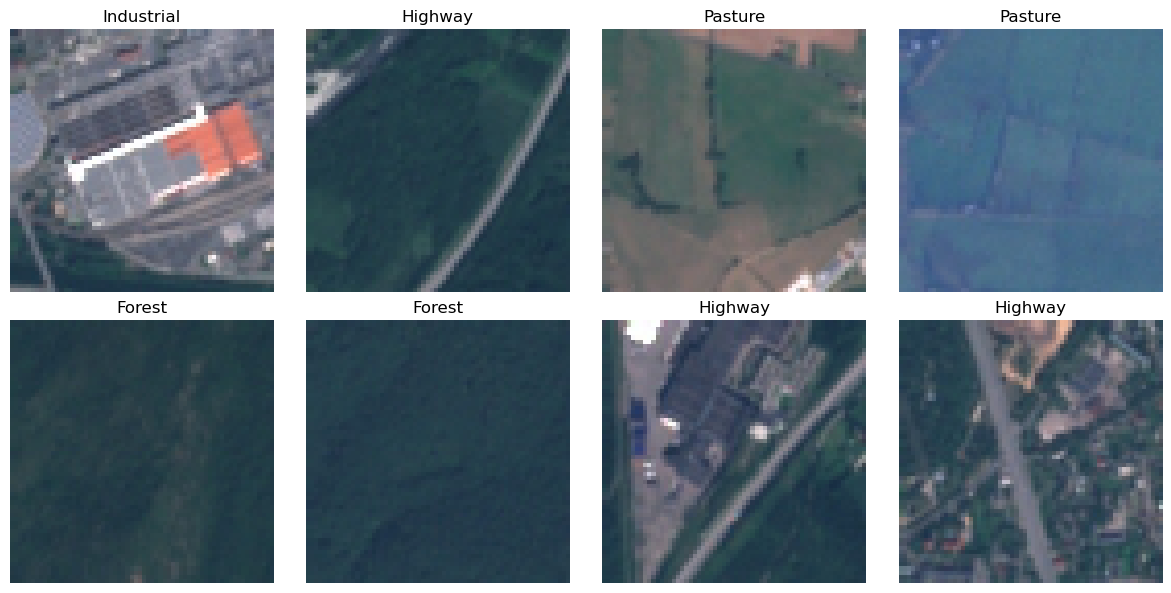

In [18]:
def imshow(img, title=None):
    """Display image"""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        ax.imshow(images[idx].numpy().transpose((1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        ax.set_title(SELECTED_CLASSES[labels[idx]])
        ax.axis('off')
plt.tight_layout()
plt.show()

## 5. Define CNN Model

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Conv block 1
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 64x64 -> 32x32
        
        # Conv block 2
        x = self.pool(self.relu(self.bn2(self.conv2(x))))  # 32x32 -> 16x16
        
        # Conv block 3
        x = self.pool(self.relu(self.bn3(self.conv3(x))))  # 16x16 -> 8x8
        
        # Conv block 4
        x = self.pool(self.relu(self.bn4(self.conv4(x))))  # 8x8 -> 4x4
        
        # Flatten
        x = x.view(-1, 256 * 4 * 4)
        
        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Initialize model
model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (relu)

## 6. Define Loss Function and Optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

## 7. Training Function

In [21]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100 * correct / total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

## 8. Validation Function

In [22]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100 * correct / total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

## 9. Training Loop

In [23]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = 'best_cnn_model.pth'

print("Starting training...\n")
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✓ Best model saved with validation accuracy: {best_val_acc:.2f}%")
    
    print()

print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:18<00:00,  3.34it/s, loss=0.1941, acc=92.75%]



Train Loss: 0.4770, Train Acc: 83.29%
Val Loss: 0.2096, Val Acc: 92.75%
✓ Best model saved with validation accuracy: 92.75%

Epoch 2/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 14.94it/s, loss=0.1145, acc=95.15%]


Train Loss: 0.2638, Train Acc: 90.76%
Val Loss: 0.1638, Val Acc: 95.15%
✓ Best model saved with validation accuracy: 95.15%

Epoch 3/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.98it/s, loss=0.1549, acc=95.40%]


Train Loss: 0.2184, Train Acc: 92.50%
Val Loss: 0.1468, Val Acc: 95.40%
✓ Best model saved with validation accuracy: 95.40%

Epoch 4/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.76it/s, loss=0.1452, acc=96.15%]



Train Loss: 0.2061, Train Acc: 93.06%
Val Loss: 0.1061, Val Acc: 96.15%
✓ Best model saved with validation accuracy: 96.15%

Epoch 5/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 11.95it/s, loss=0.2450, acc=90.60%]


Train Loss: 0.1680, Train Acc: 94.19%
Val Loss: 0.2028, Val Acc: 90.60%

Epoch 6/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 12.42it/s, loss=0.0733, acc=96.10%]


Train Loss: 0.1724, Train Acc: 94.31%
Val Loss: 0.1267, Val Acc: 96.10%

Epoch 7/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.72it/s, loss=0.0905, acc=96.55%]



Train Loss: 0.1272, Train Acc: 95.66%
Val Loss: 0.0919, Val Acc: 96.55%
✓ Best model saved with validation accuracy: 96.55%

Epoch 8/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 14.30it/s, loss=0.1298, acc=97.00%]


Train Loss: 0.1302, Train Acc: 95.70%
Val Loss: 0.0800, Val Acc: 97.00%
✓ Best model saved with validation accuracy: 97.00%

Epoch 9/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 12.40it/s, loss=0.6402, acc=88.45%]


Train Loss: 0.1169, Train Acc: 96.06%
Val Loss: 0.9109, Val Acc: 88.45%

Epoch 10/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:05<00:00, 12.34it/s, loss=0.0940, acc=96.15%]


Train Loss: 0.0952, Train Acc: 96.71%
Val Loss: 0.1097, Val Acc: 96.15%

Epoch 11/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.98it/s, loss=0.1138, acc=95.15%]


Train Loss: 0.0875, Train Acc: 97.20%
Val Loss: 0.1367, Val Acc: 95.15%

Epoch 12/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 15.41it/s, loss=0.0126, acc=94.60%]


Train Loss: 0.0844, Train Acc: 97.33%
Val Loss: 0.1689, Val Acc: 94.60%

Epoch 13/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.30it/s, loss=0.0046, acc=98.75%]


Train Loss: 0.0681, Train Acc: 97.84%
Val Loss: 0.0374, Val Acc: 98.75%
✓ Best model saved with validation accuracy: 98.75%

Epoch 14/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.44it/s, loss=0.0042, acc=98.85%]


Train Loss: 0.0527, Train Acc: 98.17%
Val Loss: 0.0357, Val Acc: 98.85%
✓ Best model saved with validation accuracy: 98.85%

Epoch 15/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 14.33it/s, loss=0.0164, acc=98.40%]


Train Loss: 0.0445, Train Acc: 98.74%
Val Loss: 0.0531, Val Acc: 98.40%

Epoch 16/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 14.99it/s, loss=0.0003, acc=98.40%]


Train Loss: 0.0323, Train Acc: 98.90%
Val Loss: 0.0520, Val Acc: 98.40%

Epoch 17/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.58it/s, loss=0.0020, acc=98.45%]


Train Loss: 0.0441, Train Acc: 98.54%
Val Loss: 0.0514, Val Acc: 98.45%

Epoch 18/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 15.11it/s, loss=0.0245, acc=98.50%]


Train Loss: 0.0347, Train Acc: 98.91%
Val Loss: 0.0556, Val Acc: 98.50%

Epoch 19/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 15.35it/s, loss=0.0023, acc=98.80%]


Train Loss: 0.0218, Train Acc: 99.28%
Val Loss: 0.0481, Val Acc: 98.80%

Epoch 20/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 13.62it/s, loss=0.0081, acc=98.70%]


Train Loss: 0.0219, Train Acc: 99.33%
Val Loss: 0.0441, Val Acc: 98.70%

Epoch 21/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 14.54it/s, loss=0.0003, acc=99.00%]



Train Loss: 0.0192, Train Acc: 99.34%
Val Loss: 0.0442, Val Acc: 99.00%
✓ Best model saved with validation accuracy: 99.00%

Epoch 22/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 14.62it/s, loss=0.0404, acc=98.30%]


Train Loss: 0.0252, Train Acc: 99.15%
Val Loss: 0.0597, Val Acc: 98.30%

Epoch 23/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 12.97it/s, loss=0.0003, acc=99.00%]


Train Loss: 0.0172, Train Acc: 99.45%
Val Loss: 0.0488, Val Acc: 99.00%

Epoch 24/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:03<00:00, 16.40it/s, loss=0.0002, acc=98.95%]


Train Loss: 0.0156, Train Acc: 99.51%
Val Loss: 0.0524, Val Acc: 98.95%

Epoch 25/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:03<00:00, 16.08it/s, loss=0.0001, acc=98.75%]


Train Loss: 0.0109, Train Acc: 99.61%
Val Loss: 0.0516, Val Acc: 98.75%

Epoch 26/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:03<00:00, 16.29it/s, loss=0.0016, acc=98.40%]


Train Loss: 0.0140, Train Acc: 99.53%
Val Loss: 0.0588, Val Acc: 98.40%

Epoch 27/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:03<00:00, 16.12it/s, loss=0.0003, acc=98.80%]


Train Loss: 0.0083, Train Acc: 99.75%
Val Loss: 0.0479, Val Acc: 98.80%

Epoch 28/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:03<00:00, 16.24it/s, loss=0.0003, acc=98.90%]


Train Loss: 0.0073, Train Acc: 99.85%
Val Loss: 0.0395, Val Acc: 98.90%

Epoch 29/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:03<00:00, 15.88it/s, loss=0.0000, acc=98.95%]


Train Loss: 0.0074, Train Acc: 99.71%
Val Loss: 0.0379, Val Acc: 98.95%

Epoch 30/30
--------------------------------------------------


Validation: 100%|██████████| 63/63 [00:04<00:00, 15.33it/s, loss=0.0033, acc=98.30%]

Train Loss: 0.0085, Train Acc: 99.75%
Val Loss: 0.0525, Val Acc: 98.30%

Training completed! Best validation accuracy: 99.00%


## 10. Plot Training History

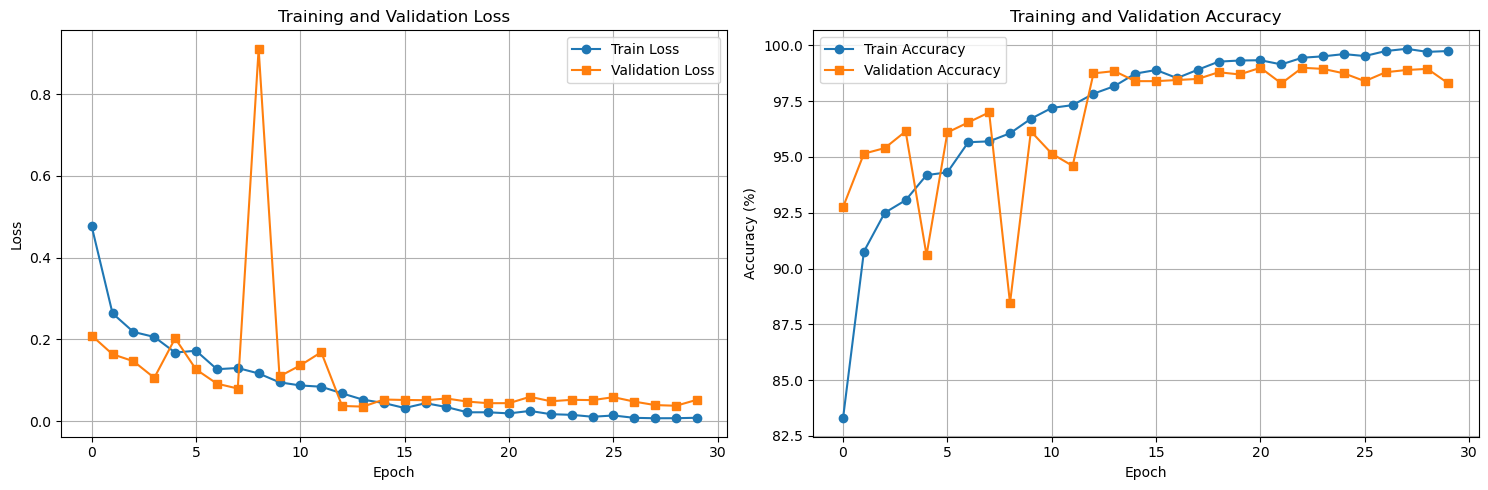

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Load Best Model and Evaluate

In [25]:
# Load best model
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded!")

# Evaluate on validation set
val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
print(f"\nFinal Validation Accuracy: {val_acc:.2f}%")

Best model loaded!


Validation: 100%|██████████| 63/63 [00:06<00:00,  9.15it/s, loss=0.0003, acc=99.00%]


Final Validation Accuracy: 99.00%


## 12. Confusion Matrix

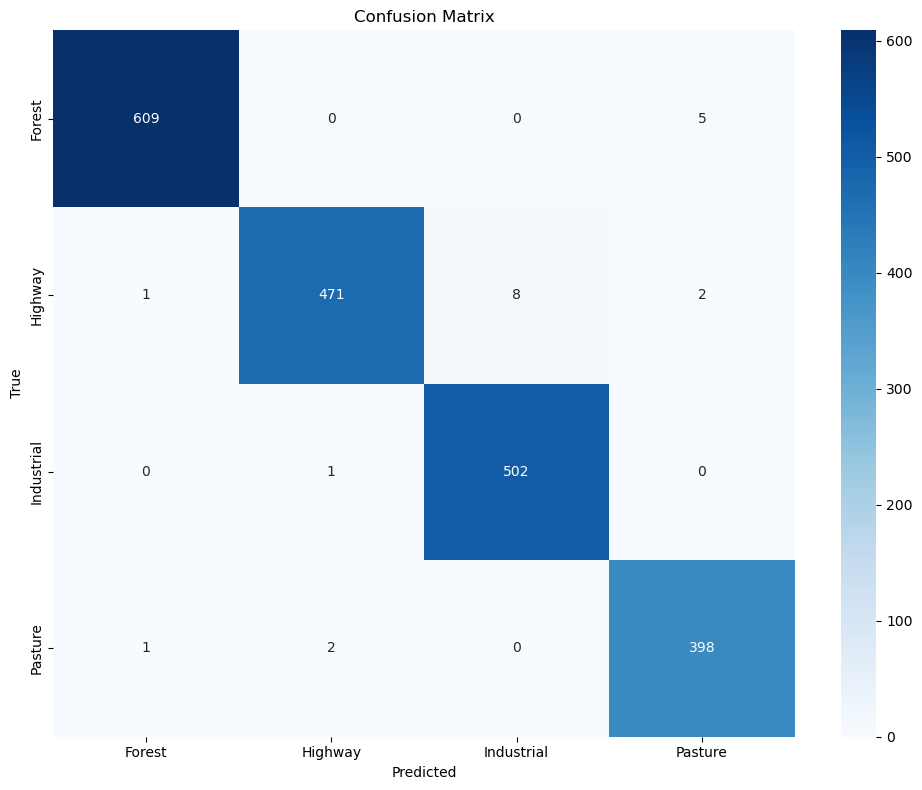


Classification Report:
              precision    recall  f1-score   support

      Forest       1.00      0.99      0.99       614
     Highway       0.99      0.98      0.99       482
  Industrial       0.98      1.00      0.99       503
     Pasture       0.98      0.99      0.99       401

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



In [26]:
# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=SELECTED_CLASSES, 
            yticklabels=SELECTED_CLASSES)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=SELECTED_CLASSES))

## 13. Visualize Predictions

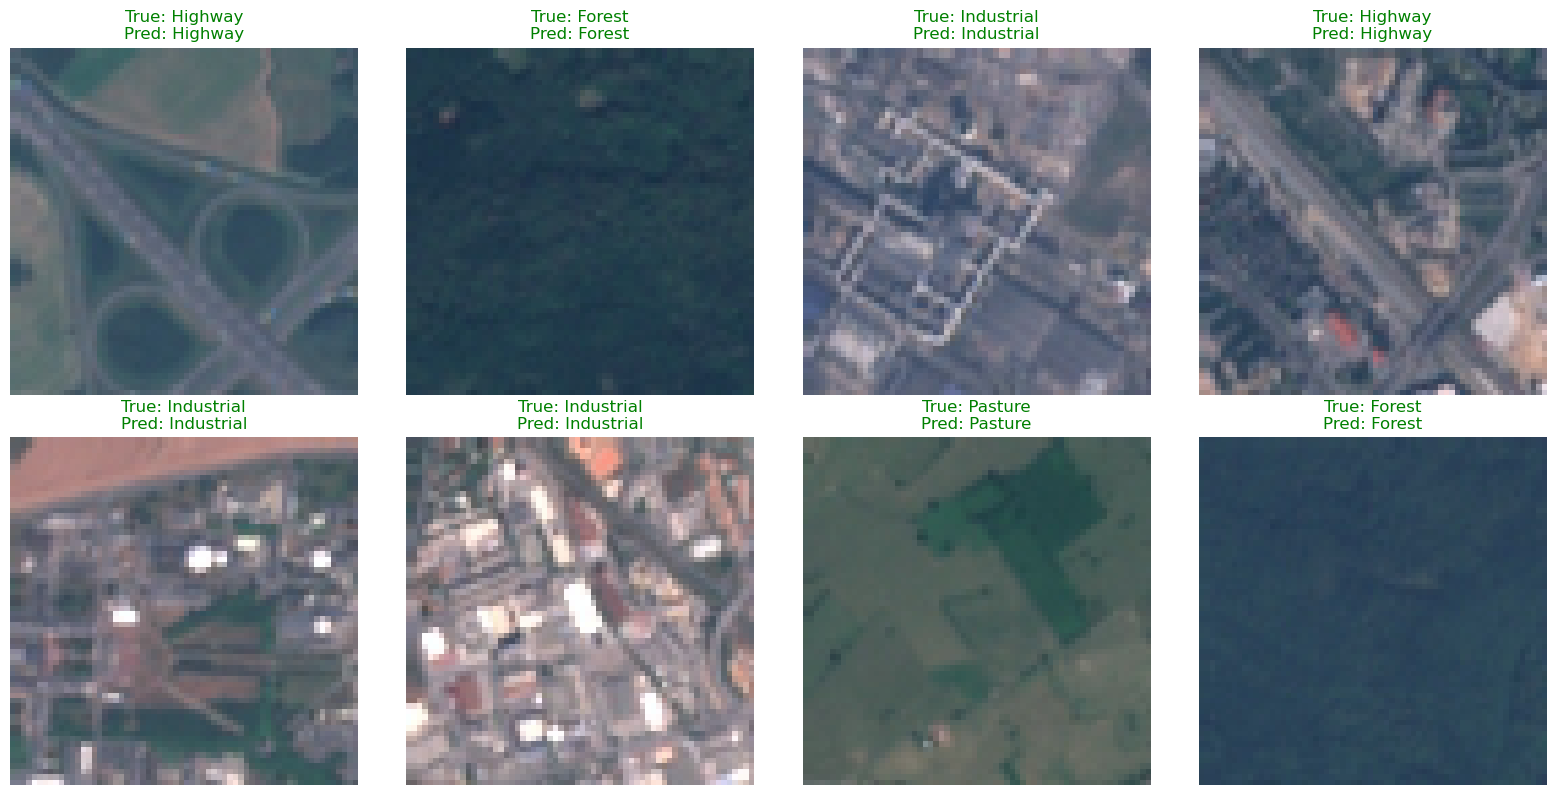

In [27]:
def visualize_predictions(model, loader, device, num_images=8):
    model.eval()
    images_shown = 0
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(len(images)):
                if images_shown >= num_images:
                    break
                
                img = images[i].cpu()
                true_label = SELECTED_CLASSES[labels[i]]
                pred_label = SELECTED_CLASSES[predicted[i]]
                
                # Denormalize
                img = img.numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                axes[images_shown].imshow(img)
                color = 'green' if true_label == pred_label else 'red'
                axes[images_shown].set_title(f'True: {true_label}\nPred: {pred_label}', color=color)
                axes[images_shown].axis('off')
                
                images_shown += 1
            
            if images_shown >= num_images:
                break
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_loader, device)

## 14. Save Final Model

In [28]:
# Save model with additional info
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'selected_classes': SELECTED_CLASSES,
    'num_classes': NUM_CLASSES,
    'best_val_acc': best_val_acc
}, 'eurosat_cnn_final.pth')

print("Final model saved as 'eurosat_cnn_final.pth'")

Final model saved as 'eurosat_cnn_final.pth'
